# Outlier Deteksion dan Clastering

## Understanding data

Dalam kerangka kerja CRISP-DM (Cross Industry Standard Process for Data Mining), tahap Data Understanding merupakan langkah kedua setelah Business Understanding. Tujuannya adalah untuk memahami data yang dimiliki secara menyeluruh sebelum masuk ke tahap pemodelan

### Pengumpulan Data

Pada tahap ini kita mengumpulkan data menarik data dari sumber data ke dalam power BI untuk dijadikan satu kemudian dianalisis. Pada kali ini kita akan melakukan pengumpulan data Iris dari database server Aiven dari posgre dan mysql dimana data di posgre dengan kolom sepal length dan sepal widt akan dijadikan satu dengan data mysql dengan kolom petal length dan sepal length menggunakan Script Python

1. Install psycopg2 di Python environment yang dipakai Power BI untuk melakukan deteksi outlier menggunakan KNN dan klastering dengan K-means
  
    pip install psycopg2-binary pandas



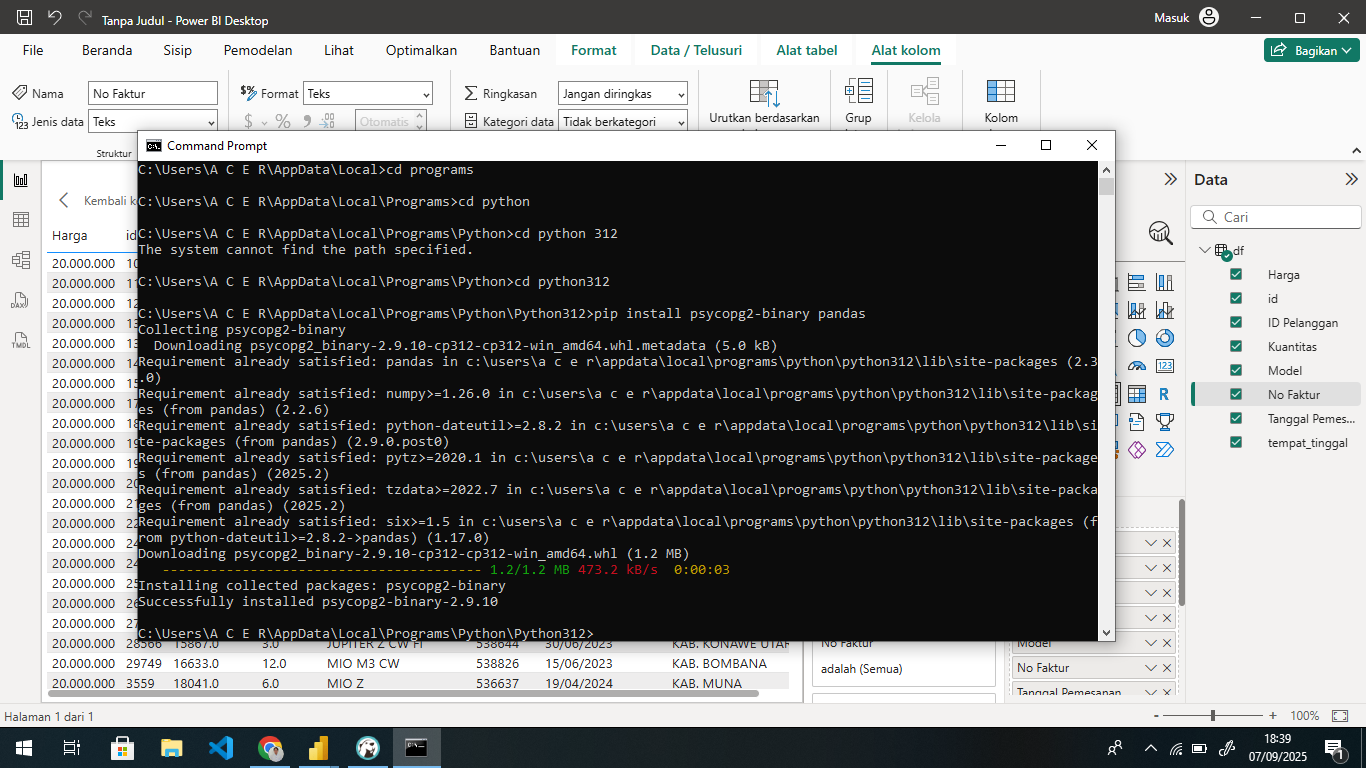

2. Buka power BI dan pilih dapatkan data dari sumber lain

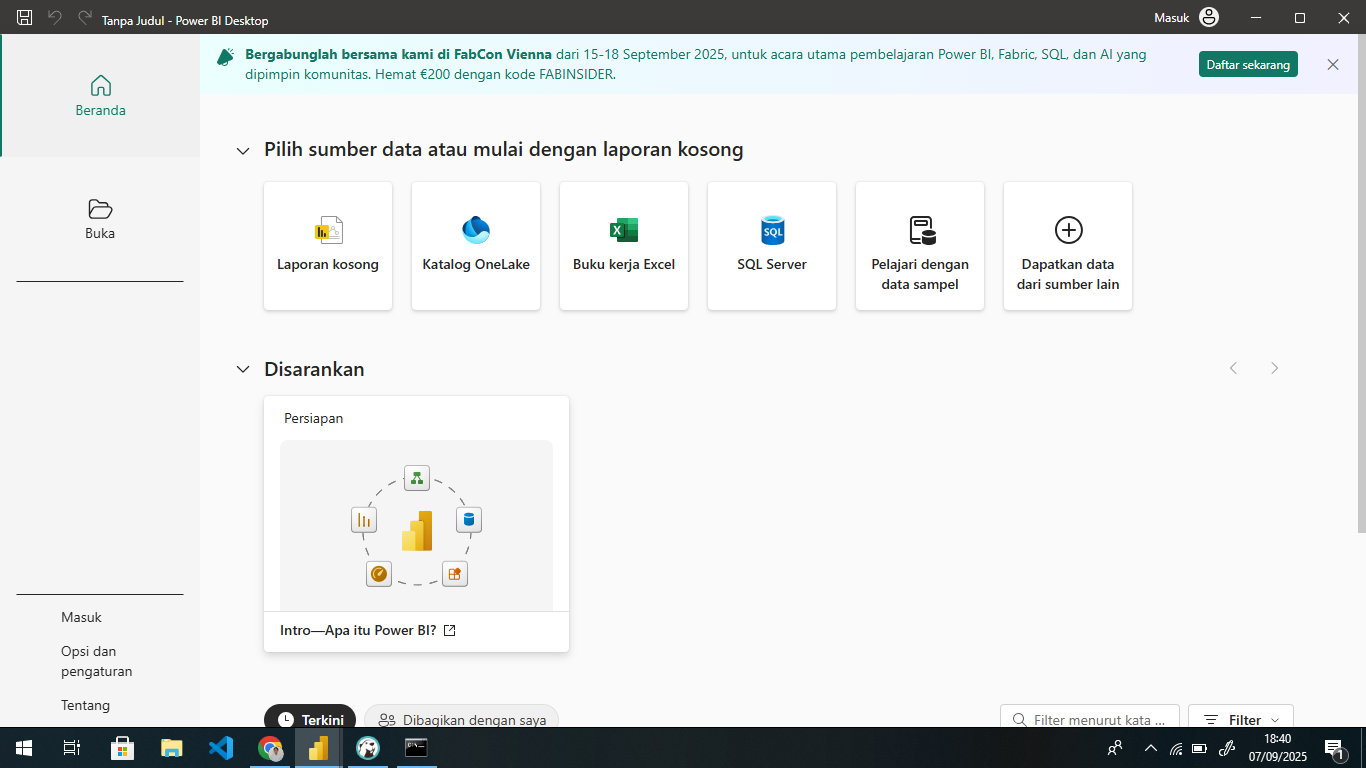

3. Cari Menu Skrip Python pada bar pencarian

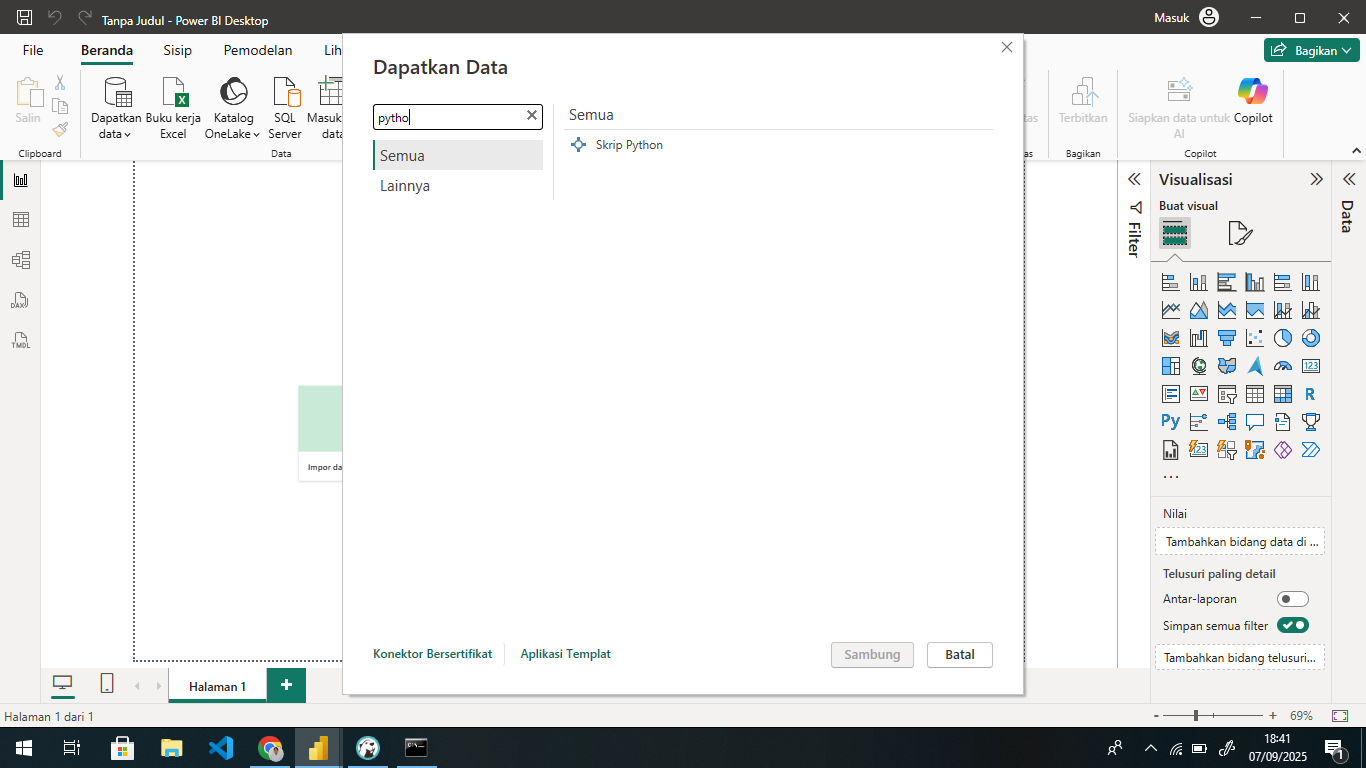

4. Coppy script Python dibawah masukkan kedalam script power BI

In [ ]:
import pandas as pd
import psycopg2

# Konfigurasi database
PG_HOST = "posgesqlpendata23-175-posgresqlpendata23-175.h.aivencloud.com"
PG_PORT = "17047"
PG_NAME = "defaultdb"
PG_USER = "avnadmin"
PG_PASS = "AVNS_XfGwRG6_6e5BdqZXovg"

# Koneksi ke PostgreSQL
conn = psycopg2.connect(
    host=PG_HOST,
    port=PG_PORT,
    dbname=PG_NAME,
    user=PG_USER,
    password=PG_PASS,
    sslmode="require"   # penting untuk koneksi Aiven
)

# Query ambil data (ubah nama_tabel sesuai dengan tabelmu)
query = "SELECT * FROM irisposgre.posgre"

# Load ke DataFrame
dataPosgre = pd.read_sql(query, conn)

# Tutup koneksi
conn.close()

# Output ke Power BI
dataPosgre

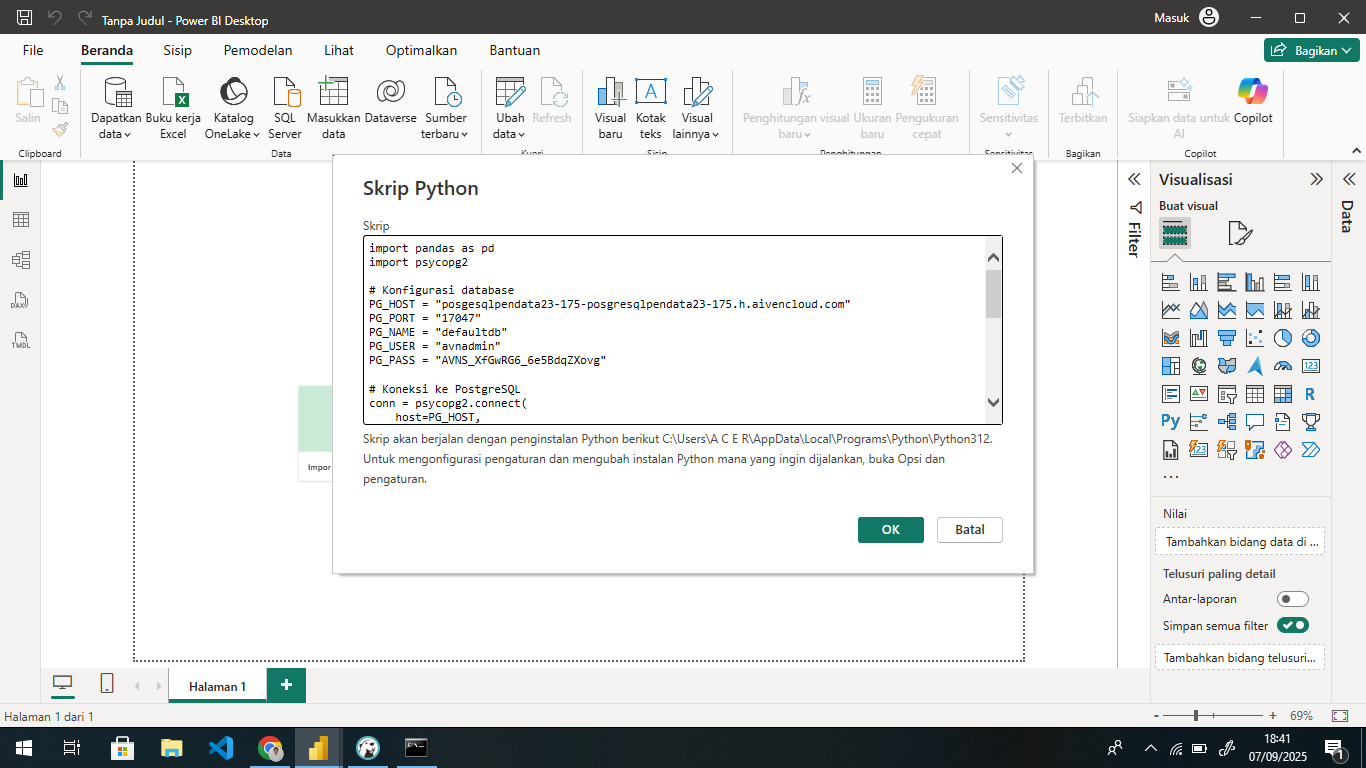

5. Klik Oke tunggu biarkan Power BI mengambil data dari server posgre ketika sudah selesai

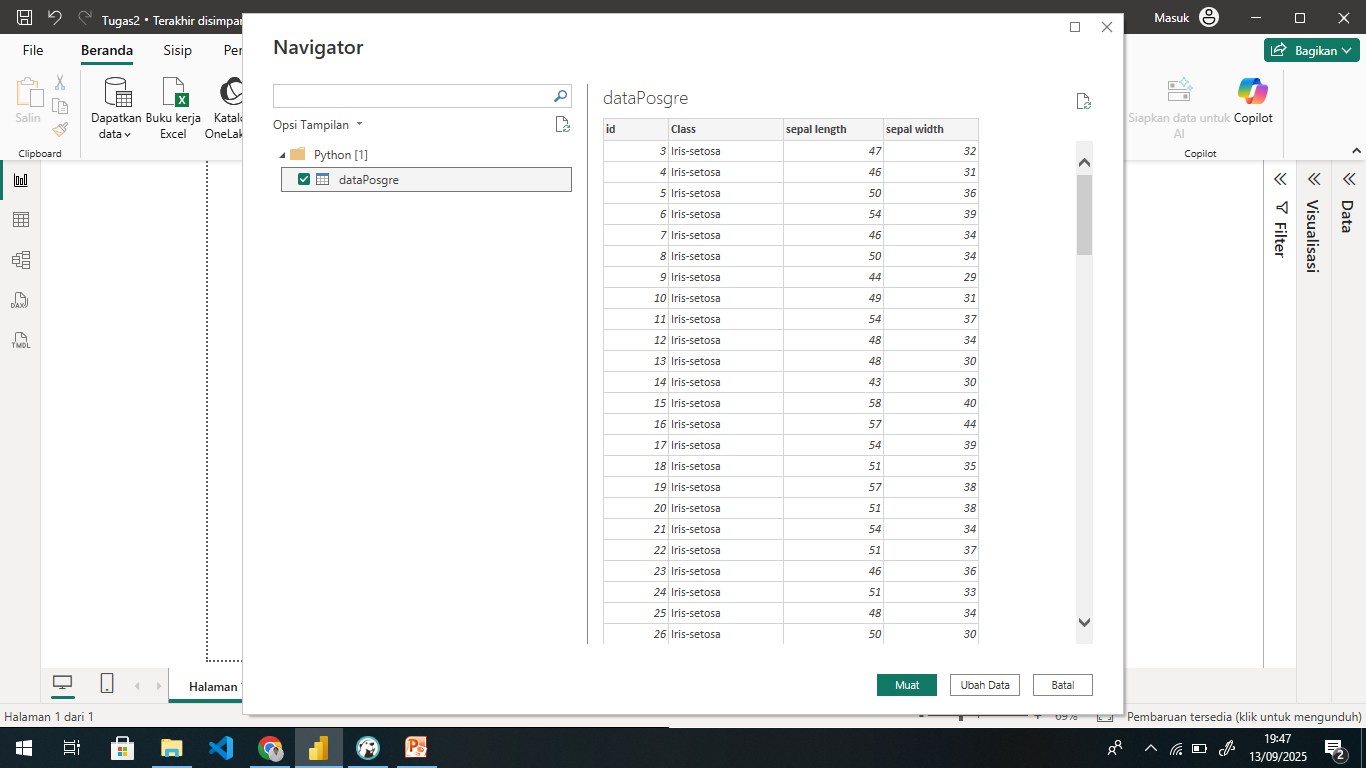

6. Klik ubah data untuk melakukan pengecekan pada data sesuaikan tipe data dengan isi data dengan mengklik icon didekat nama kolom

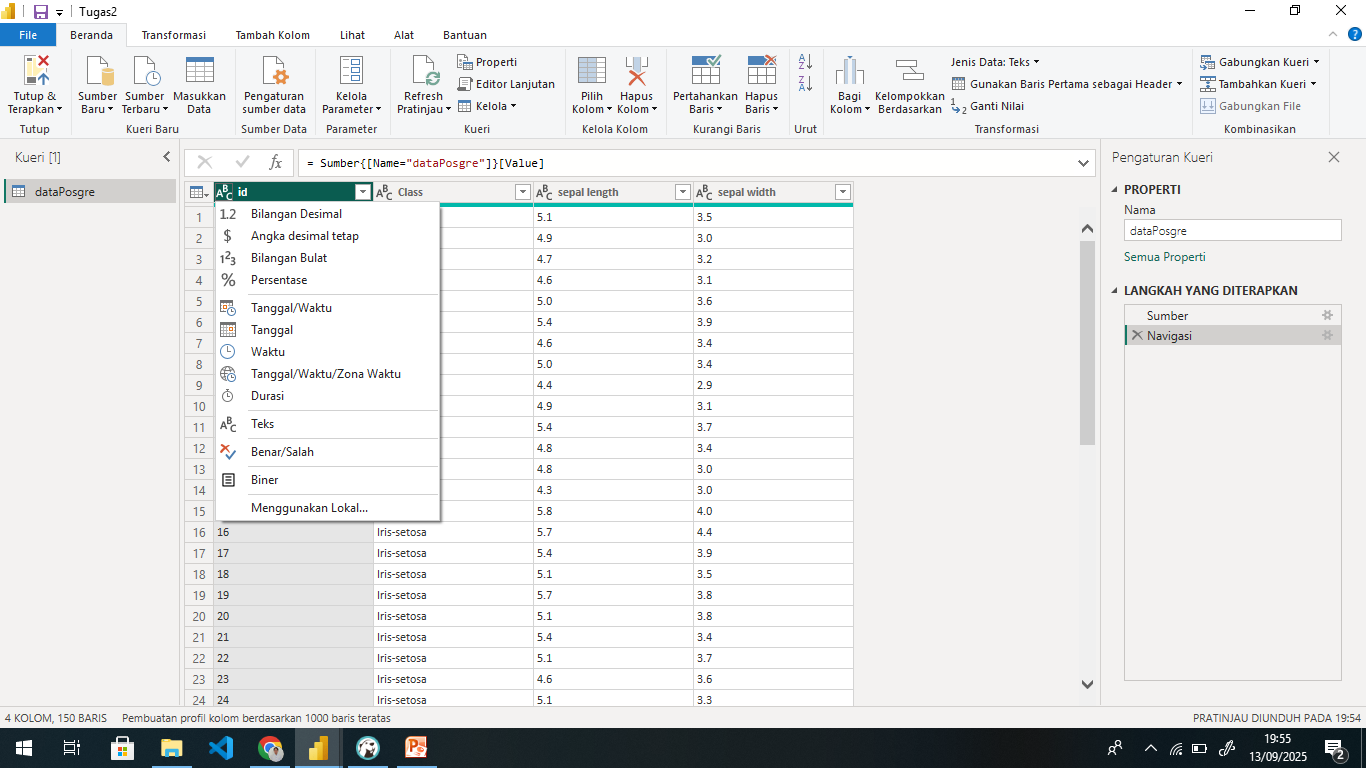

7. Jika semua data sudah sesuai kita bisa melakukan query kembali dengan mengklik sumber baru klik lainnya ulangin langkah 3 untuk memasukkan

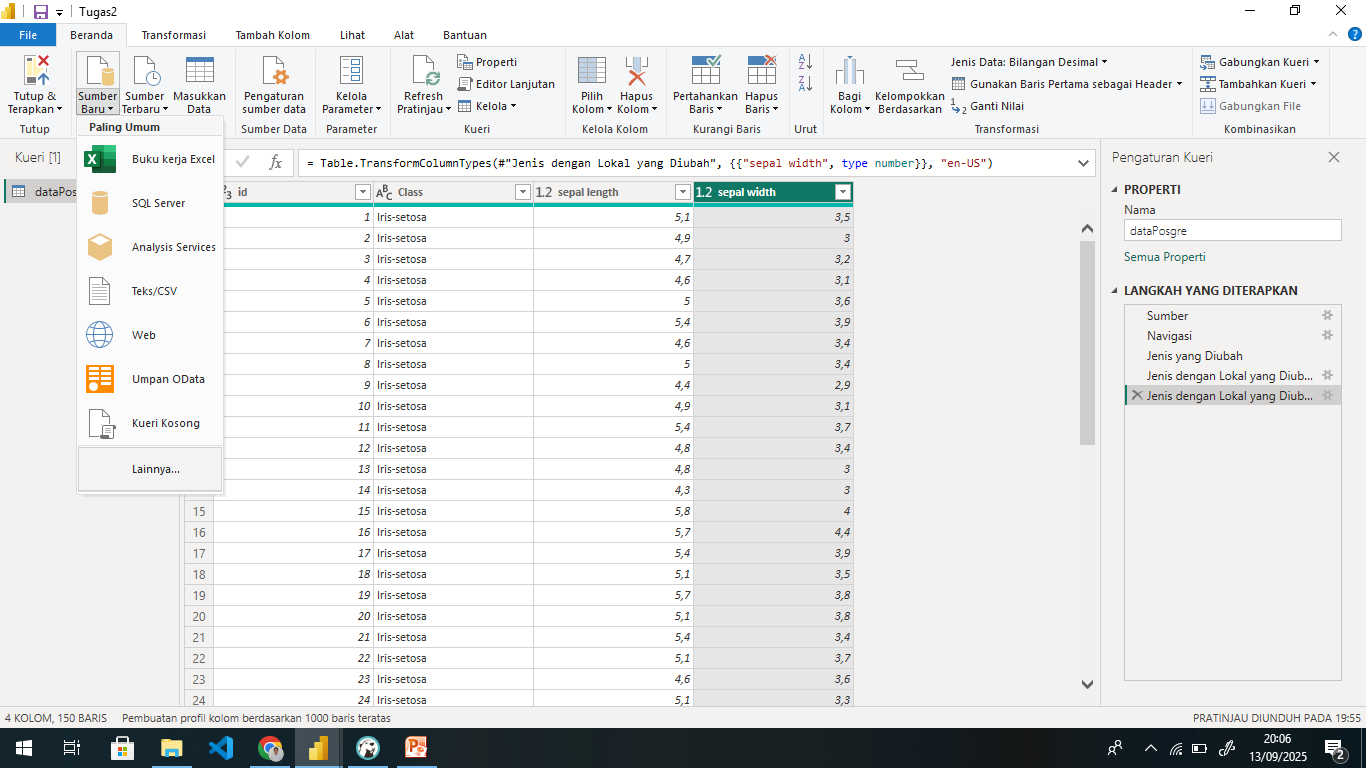

8. Salin Query tersebut untuk Mysql

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Konfigurasi koneksi MySQL
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

# Buat engine SQLAlchemy
engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# Query ambil data
query = "SELECT * FROM irismysql.flowers ORDER BY id ASC;"
dataMysql = pd.read_sql(query, engine)

# Hapus baris header duplikat (jika ada)
dataMysql = dataMysql[dataMysql["id"] != "id"]

# Konversi kolom numerik ke tipe number
for col in ["petal length", "petal width"]:
    dataMysql[col] = pd.to_numeric(dataMysql[col], errors="coerce")

print(dataMysql.head())


   id        class  petal length  petal width
0   1  Iris-setosa           1.4          0.2
1   2  Iris-setosa           1.4          0.2
2   3  Iris-setosa           1.3          0.2
3   4  Iris-setosa           1.5          0.2
4   5  Iris-setosa           1.4          0.2
5   6  Iris-setosa           1.7          0.4
6   7  Iris-setosa           1.4          0.3
7   8  Iris-setosa           1.5          0.2
8   9  Iris-setosa           1.4          0.2
9  10  Iris-setosa           1.5          0.1


9. Jika 2 Table sudah terbenttuk data dari Mysql dan data dari Posgre selanjutnya gabungkan kedua table tersebut dengan duplikat table posgre dan klik editor lanjuta salin code berikut

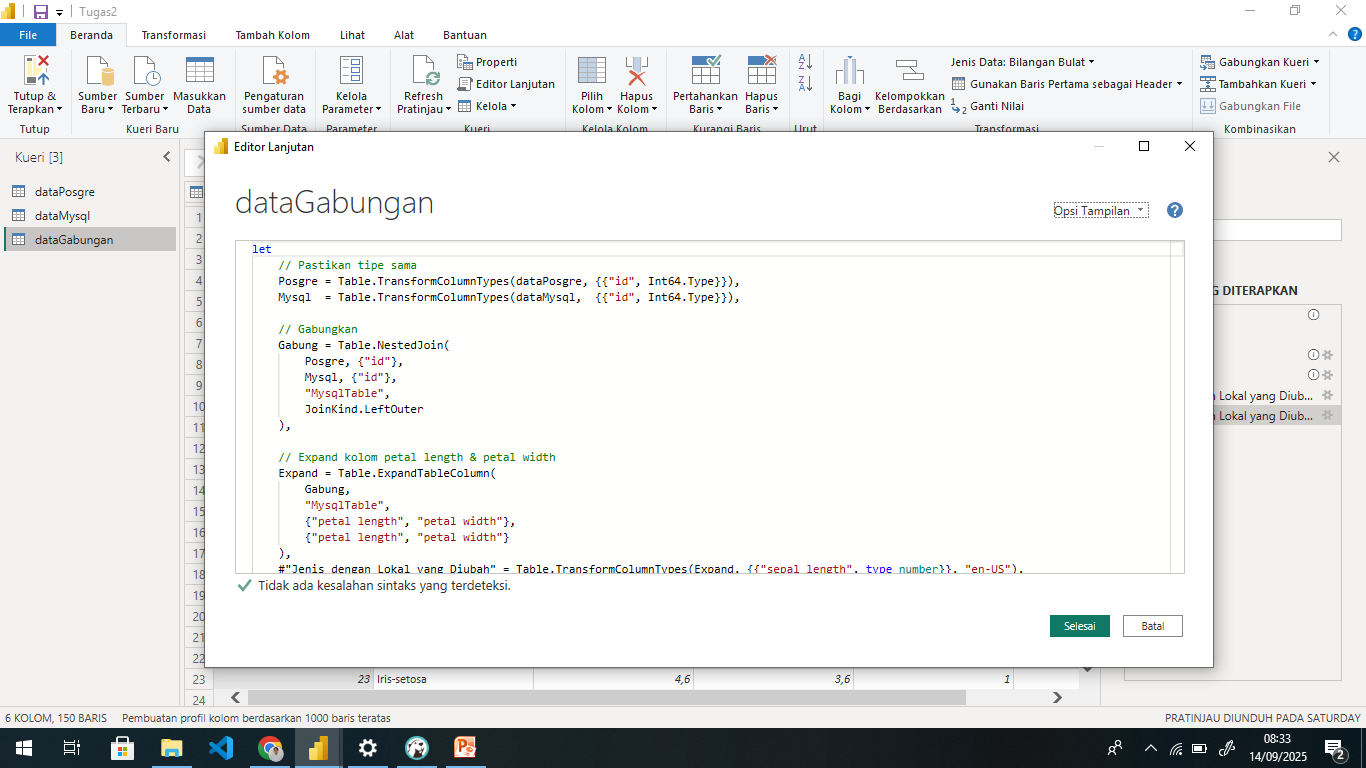

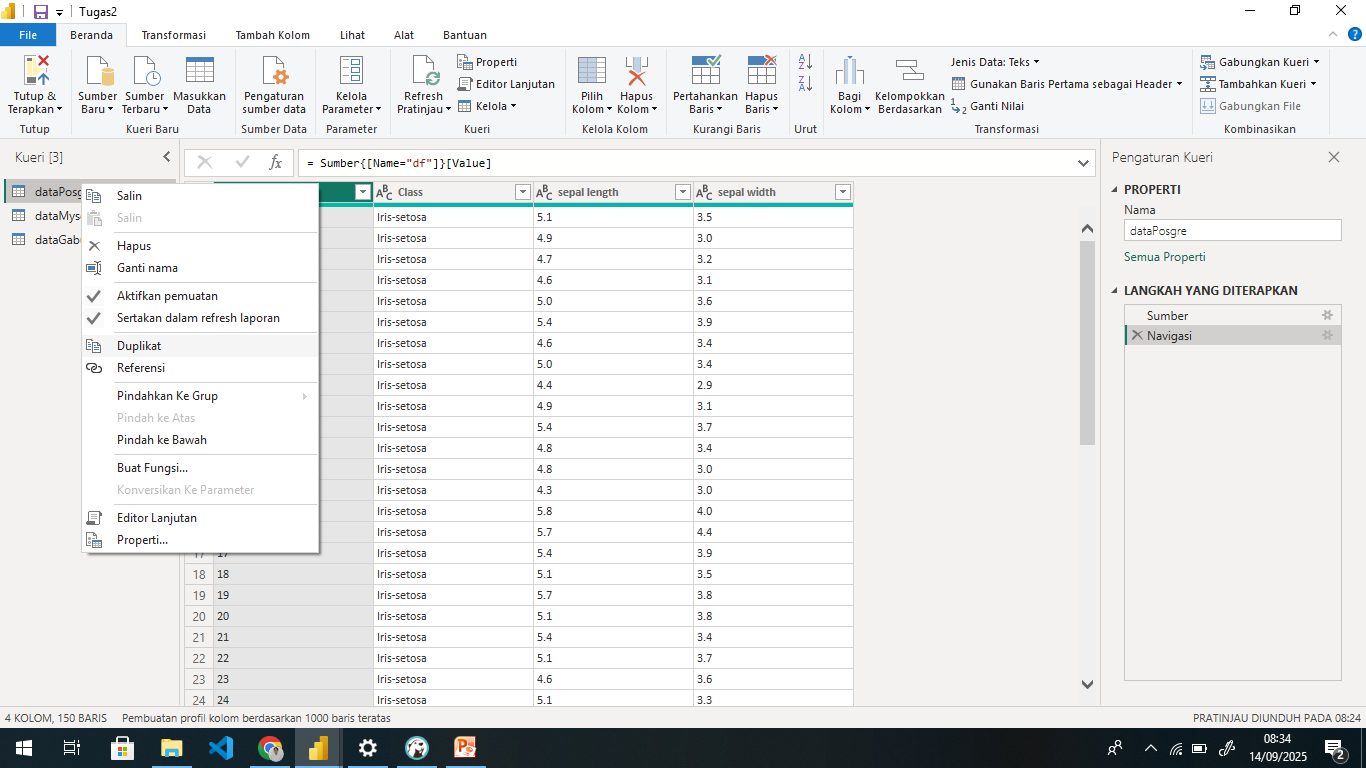

In [ ]:
let
    // Pastikan tipe sama
    Posgre = Table.TransformColumnTypes(dataPosgre, {{"id", Int64.Type}}),
    Mysql  = Table.TransformColumnTypes(dataMysql,  {{"id", Int64.Type}}),

    // Gabungkan
    Gabung = Table.NestedJoin(
        Posgre, {"id"},
        Mysql, {"id"},
        "MysqlTable",
        JoinKind.LeftOuter
    ),

    // Expand kolom petal length & petal width
    Expand = Table.ExpandTableColumn(
        Gabung,
        "MysqlTable",
        {"petal length", "petal width"},
        {"petal length", "petal width"}
    ),
    #"Jenis dengan Lokal yang Diubah" = Table.TransformColumnTypes(Expand, {{"sepal length", type number}}, "en-US"),
    #"Jenis dengan Lokal yang Diubah1" = Table.TransformColumnTypes(#"Jenis dengan Lokal yang Diubah", {{"sepal width", type number}}, "en-US")
in
    #"Jenis dengan Lokal yang Diubah1"

### Identifikasi Oulier menggunakan metode KNN

K-Nearest Neighbors (KNN) adalah algoritma berbasis kedekatan (proximity-based) yang digunakan dalam klasifikasi, regresi, dan deteksi outlier. Dalam konteks outlier detection, KNN menghitung jarak antara setiap titik data dan k tetangga terdekatnya. Jika suatu titik jauh dari tetangga-tetangganya, maka titik tersebut dianggap sebagai outlier.

#### Cara kerja KNN dalam deteksi Outlier

1. Menghitung jarak

Untuk setiap data dalam dataset, KNN menghitung jaraknya terhadap semua titik lain.
Umumnya menggunakan Euclidean Distance dengan menjumlahkan selisih dari setiap fitur antar titiknya:

$d(A, B) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

Pada kasus ini, fitur yang digunakan:
* Sepal Length
* Sepal Width
* Petal Length
* Petal Width

2. Mencari k Tetangga Terdekat
Untuk setiap titik data,
* cari k tetangga terdekat (misalnya k = 3).
* Urutkan data berdasarkan distance dan ambil 3 tetangga terdekat.

3. Menghitung Rata-rata Jarak ke k Tetangga Terdekat
Untuk setiap titik

* hitung rata-rata jarak ke 3 tetangga terdekat:

$
R = \frac{d_1 + d_2 + d_3}{3}
$

* Semakin besar nilai rata-rata distance, semakin besar kemungkinan titik tersebut adalah outlier.

4. Menentukan Outlier

* Gunakan threshold berdasarkan nilai rata-rata distance dari semua titik.

* Outlier adalah data yang memiliki rata-rata jarak lebih besar dari threshold tertentu (misalnya di atas Q3 + 1.5 * IQR dalam boxplot).


1. Disini saya menggunakan pycaret untuk menghitung knn outliernya pastikan minimal versi pytho 3.11 kemudian duplicat data gabungan beri nama dataOutlier untuk menghasilkan table outlier salin code berikut lalu oke

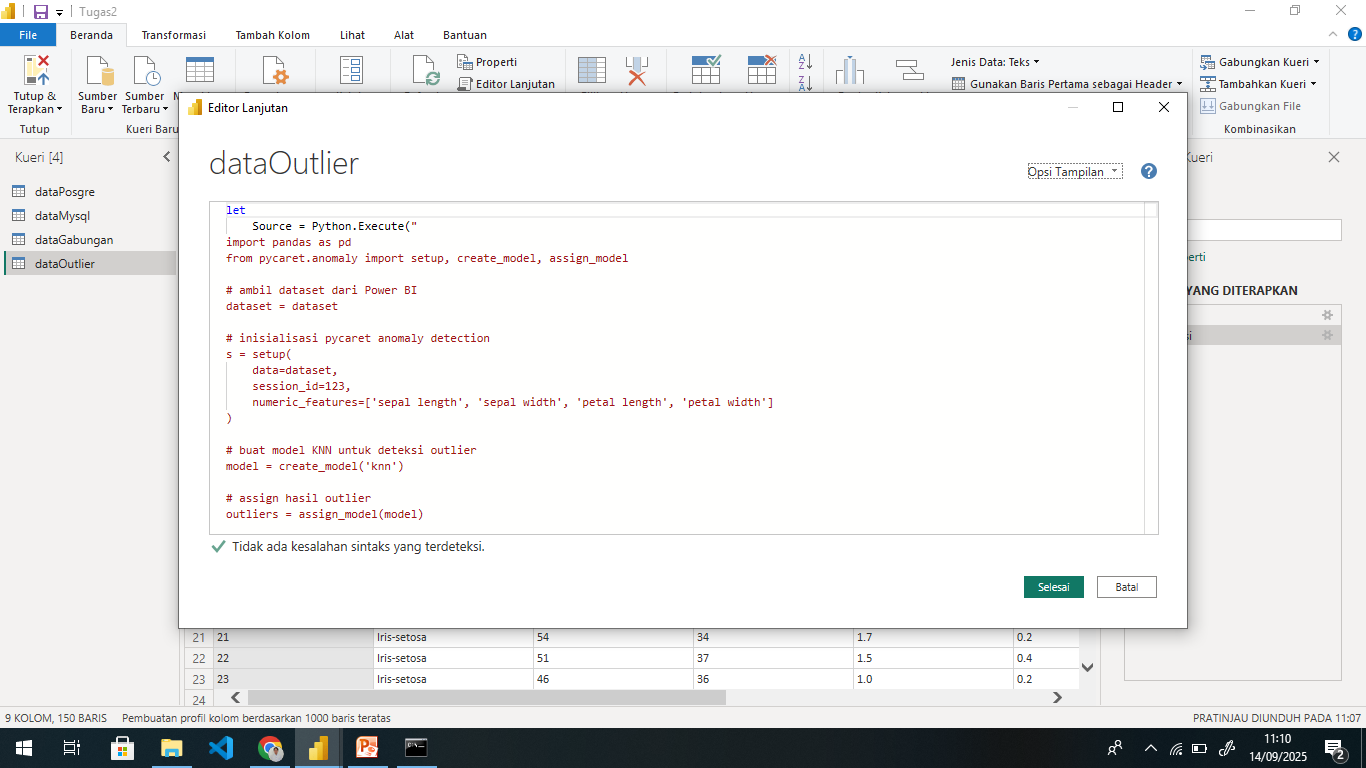

In [ ]:
let
    Source = Python.Execute("
import pandas as pd
from pycaret.anomaly import setup, create_model, assign_model

# ambil dataset dari Power BI
dataset = dataset

# inisialisasi pycaret anomaly detection
s = setup(
    data=dataset,
    session_id=123,
    numeric_features=['sepal length', 'sepal width', 'petal length', 'petal width']
)

# buat model KNN untuk deteksi outlier
model = create_model('knn')

# assign hasil outlier
outliers = assign_model(model)

# tambahkan label Yes/No
outliers['OutlierLabel'] = outliers['Anomaly'].apply(lambda x: 'Yes' if x == 1 else 'No')

outliers
", [dataset=dataGabungan]),
    Result = Source{[Name="outliers"]}[Value]
in
    Result

2. Maka akan muncul kolom baru yaitu anomaly dan scorenya dimaan nilai 1 yes menunjukkan outlier

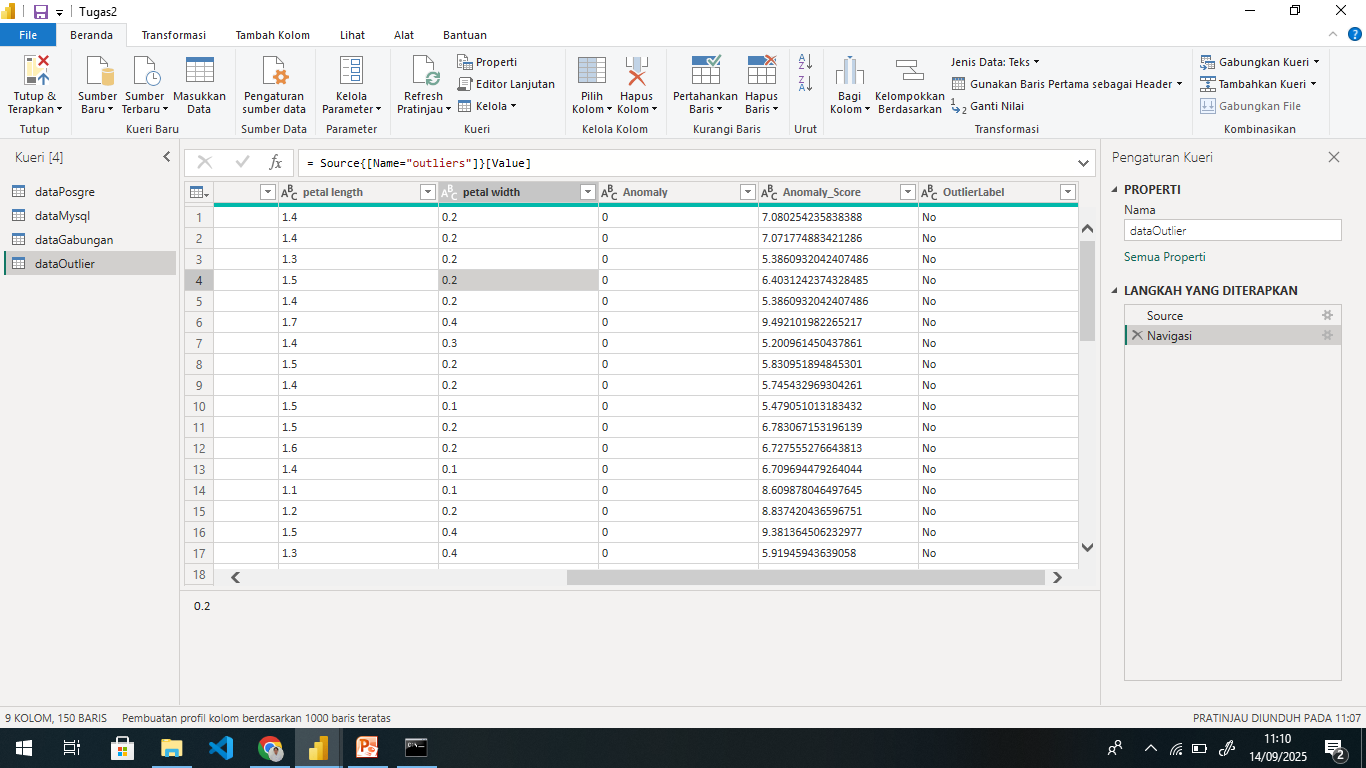

### Identifikasi Outlier menggunakan ABOD

Angle-Based Outlier Detection (ABOD) adalah pendekatan geometris untuk mengidentifikasi outlier dalam data berdimensi tinggi dengan menganalisis varians sudut yang dibentuk oleh vektor-vektor dari suatu titik ke tetangganya.

Dalam satu himpunan data, titik-titik normal cenderung memiliki sudut-sudut yang serupa antara pasangan vektor yang menghubungkannya ke titik lain. Sebaliknya, outlier sering kali terletak di tepi dan membentuk rentang sudut yang sangat luas terhadap tetangganya — artinya, varians sudut mereka tinggi.



#### **Cara Kerja Algoritma ABOD (Angle-Based Outlier Detection)**

Algoritma ABOD mengidentifikasi pencilan (outlier) berdasarkan varians sudut antara vektor-vektor yang menghubungkan satu titik dengan pasangan titik lainnya di dalam dataset. Titik yang merupakan pencilan cenderung memiliki varians sudut yang lebih tinggi dibandingkan titik yang berada di dalam cluster (inlier).

Berikut adalah langkah-langkah kerjanya:

1.  **Untuk setiap titik $p_i$ dalam dataset:**
    * Hitung semua vektor pasangan dari titik $p_i$ ke semua titik lainnya ($p_j$ dan $p_k$). Vektor ini direpresentasikan sebagai:
        $$
        \vec{v}_{ij} = p_j - p_i
        $$
    * Untuk setiap kemungkinan pasangan vektor yang berpusat di $p_i$, misalnya $(\vec{v}_{ij}, \vec{v}_{ik})$, hitung sudut $\theta_{ijk}$ di antara keduanya menggunakan rumus *dot product*:
        $$
        \cos(\theta_{ijk}) = \frac{\vec{v}_{ij} \cdot \vec{v}_{ik}}{\|\vec{v}_{ij}\| \|\vec{v}_{ik}\|}
        $$
        Dari sini, nilai sudut $\theta_{ijk}$ dapat diperoleh.
    * Setelah mendapatkan semua kemungkinan sudut yang terbentuk dari titik $p_i$ sebagai pusatnya, hitung nilai varians dari spektrum sudut tersebut.

2.  **Hitung Skor Outlier (ABOD Score):**
    Skor outlier untuk sebuah titik $p_i$ didefinisikan sebagai varians dari semua sudut $\theta_{ijk}$ dimana $p_i$ menjadi titik pusatnya.
    $$
    ABOD(p_i) = \underset{j,k \neq i}{\text{Var}}(\theta_{ijk})
    $$

3.  **Identifikasi Outlier:**
    Titik-titik dengan nilai skor ABOD yang tinggi dianggap sebagai outlier.

    * **Intuisi**:
        * **Inlier (Bukan Outlier)**: Sebuah titik yang dikelilingi oleh banyak tetangga (berada di dalam cluster) akan memiliki sudut-sudut yang relatif sempit dan konsisten. Hal ini menghasilkan nilai varians sudut yang **rendah**.
        * **Outlier**: Sebuah titik yang terisolasi dari cluster utama akan memiliki sudut yang sangat bervariasi ketika dihubungkan dengan titik-titik lainnya. Beberapa sudut mungkin sangat lebar, sementara yang lain sempit. Hal ini menghasilkan nilai varians sudut yang **tinggi**.

Tentu, ini adalah penjelasan langkah demi langkah untuk menentukan persentase anomali setelah mendapatkan skor dari algoritma ABOD, berdasarkan informasi yang Anda berikan.

-----

#### **Langkah-Langkah Menentukan Anomali dengan ABOD**

Setelah skor anomali untuk setiap titik data dihitung menggunakan ABOD, langkah selanjutnya adalah menggunakan skor tersebut untuk menandai titik mana yang merupakan anomali. Proses ini biasanya melibatkan penentuan ambang batas (*threshold*), baik secara manual berdasarkan persentase atau secara otomatis menggunakan metode statistik.

##### **1. Hitung Skor ABOD untuk Setiap Titik**

Langkah pertama adalah menjalankan algoritma ABOD untuk mendapatkan skor anomali bagi setiap titik $p\_i$ dalam dataset.

  * **Rumus**: $ABOD(p\_i) = \\underset{j,k \\neq i}{\\text{Var}}(\\theta\_{ijk})$
  * **Intuisi**:
      * Skor ABOD **tinggi** berarti titik terseb#ut kemungkinan besar adalah **outlier**.
      * Skor ABOD **rendah** berarti titik tersebut kemungkinan besar adalah **inlier**.
  * **Hasil**: Anda akan mendapatkan sebuah array atau list berisi skor, di mana setiap skor berkorespondensi dengan satu titik data.
      * Contoh: `[0.12, 0.45, 1.89, 0.08, 3.21, ...]`

-----

##### **2. Urutkan Skor ABOD dari Tertinggi ke Terendah**

Untuk mempermudah identifikasi, urutkan semua skor anomali secara menurun (*descending*). Titik dengan skor tertinggi akan berada di urutan pertama.

  * **Tujuan**: Menempatkan kandidat anomali terkuat di #bagian atas daftar.
  * **Kode Contoh**:
    ```python
    abod_scores_sorted = sorted(abod_scores, reverse=True)
    ```
  * **Contoh Hasil (Terurut)**: `[3.21, 1.89, 0.45, 0.12, 0.08]`

-----

##### **3. Tentukan Persentase Anomali yang Diinginkan**

Langkah ini sangat bergantung pada konteks masalah atau tujuan bisnis. Anda perlu memutuskan berapa persen dari data yang Anda anggap sebagai anomali.

| Tujuan Penggunaan | Perkiraan Persentase Anomali |
| :--- | :--- |
| Keamanan siber (sangat ketat) | 1% |
| Deteksi penipuan (*fraud*) | 5% |
| Eksplorasi data awal | 10% |
| Penelitian (sensitivitas tinggi) | 1–5% |

**Rekomendasi umum**: Mulailah dengan **1% hingga 5%**, karena anomali pada dasarnya adalah peristiwa yang jarang terjadi.

-----

##### **4. Ambil Top N Titik sebagai Anomali**

Berdasarkan persentase yang telah ditentukan, hitung jumlah titik yang akan ditandai sebagai anomali dan ambil dari daftar skor yang sudah diurutkan.

  * **Contoh Perhitungan**:
      * Jumlah total titik data: $N = 1000$
      * Persentase anomali yang diinginkan: $5%$
      * Jumlah anomali yang akan diambil: $5% \\times 1000 = 50$ titik.
  * **Kesimpulan**: Anda akan mengambil **50 titik** dengan skor ABOD tertinggi sebagai anomali.

-----

#### **5. Tentukan Threshold Otomatis (Opsional)**

Jika Anda tidak ingin menentukan persentase secara manual, ambang batas (*threshold*) dapat dihitung secara otomatis menggunakan beberapa pendekatan statistik. Titik dengan skor di atas *threshold* ini akan dianggap anomali.

##### **a. Menggunakan Kuartil (Persentil)**

Metode ini mengambil sekian persen data dengan skor teratas. Ini adalah cara paling langsung untuk menerapkan persentase.

```python
import numpy as np
# Ambil 10% data dengan skor tertinggi (skor di atas persentil ke-90)
threshold = np.percentile(abod_scores, 90)
anomalies = abod_scores > threshold
```

##### **b. Menggunakan Rata-rata dan Standar Deviasi**

Metode ini mengasumsikan skor terdistribusi normal, yang seringkali tidak demikian untuk skor anomali.

```python
mean_score = np.mean(abod_scores)
std_score = np.std(abod_scores)
# Menandai skor yang lebih dari 2 standar deviasi di atas rata-rata
threshold = mean_score + 2 * std_score
anomalies = abod_scores > threshold
```

##### **c. Menggunakan Interquartile Range (IQR)**

Ini adalah metode yang lebih **robust** (andal) karena tidak bergantung pada asumsi distribusi normal. Metode ini sama seperti yang digunakan untuk mendeteksi *outlier* pada visualisasi *boxplot*.

```python
Q1 = np.percentile(abod_scores, 25)
Q3 = np.percentile(abod_scores, 75)
IQR = Q3 - Q1
# Titik dianggap anomali jika skornya > Q3 + 1.5 * IQR
threshold = Q3 + 1.5 * IQR
anomalies = abod_scores > threshold
```

1. klik ubah data pada beranda

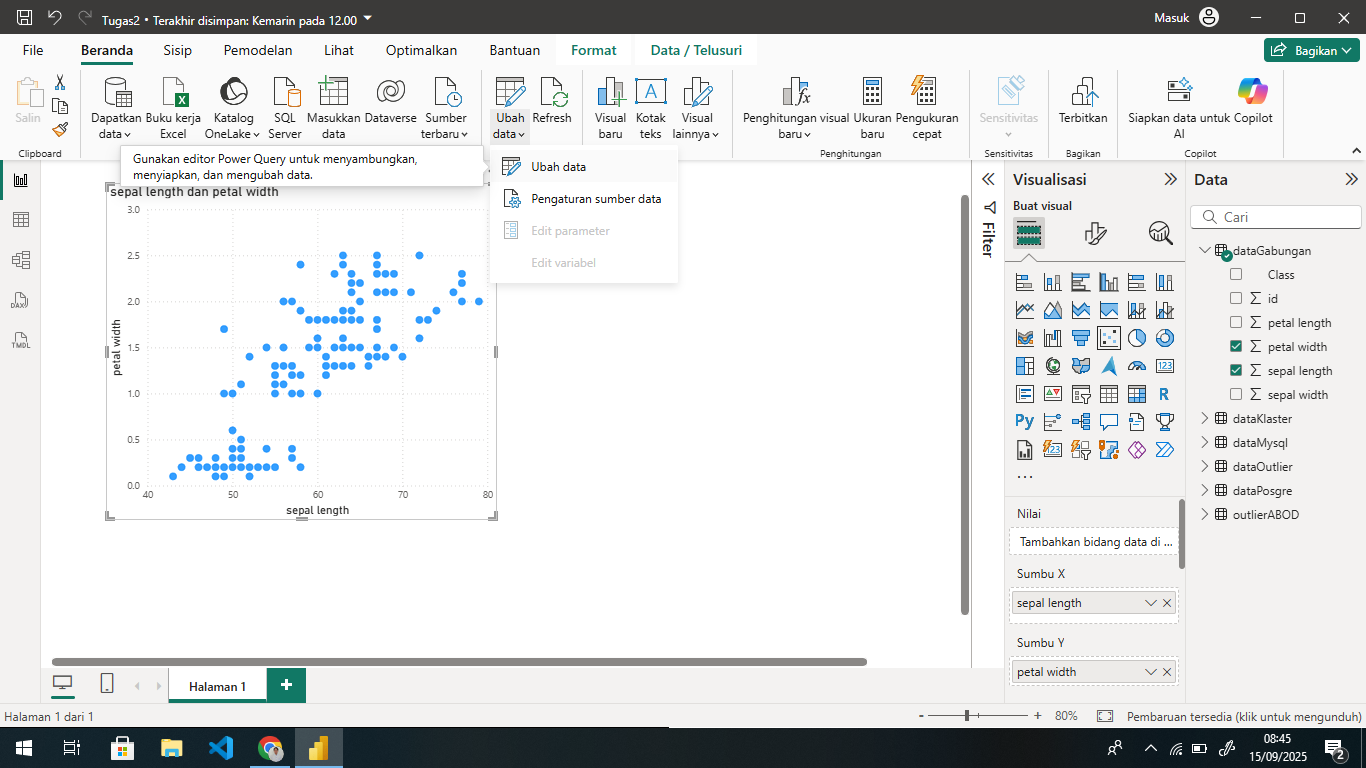

2. Duplikat data gabungan posgre mysql

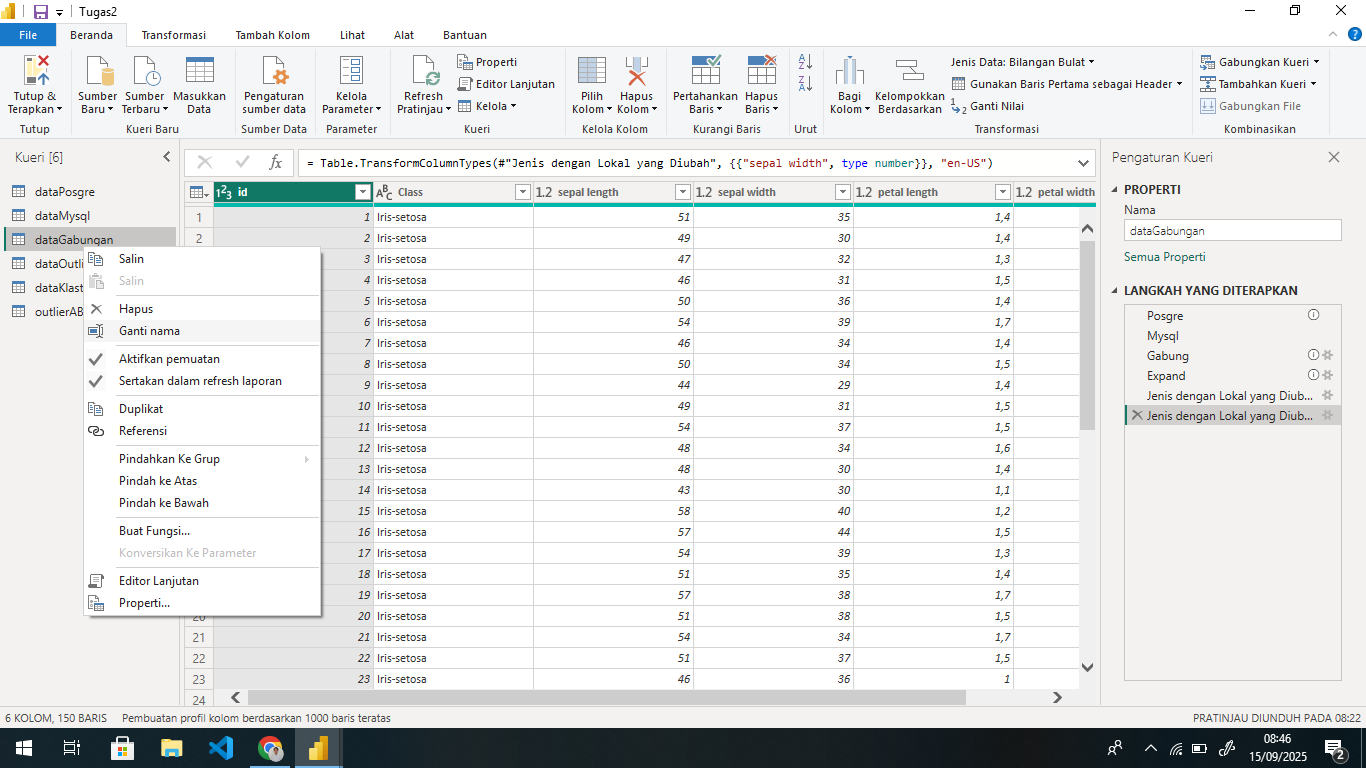

3. Ganti nama data gabungan yang sudah di duplikat dengan outlierABOD

4. klik editor lanjutan salin code dibawah dan tunggu komputasinya selesai

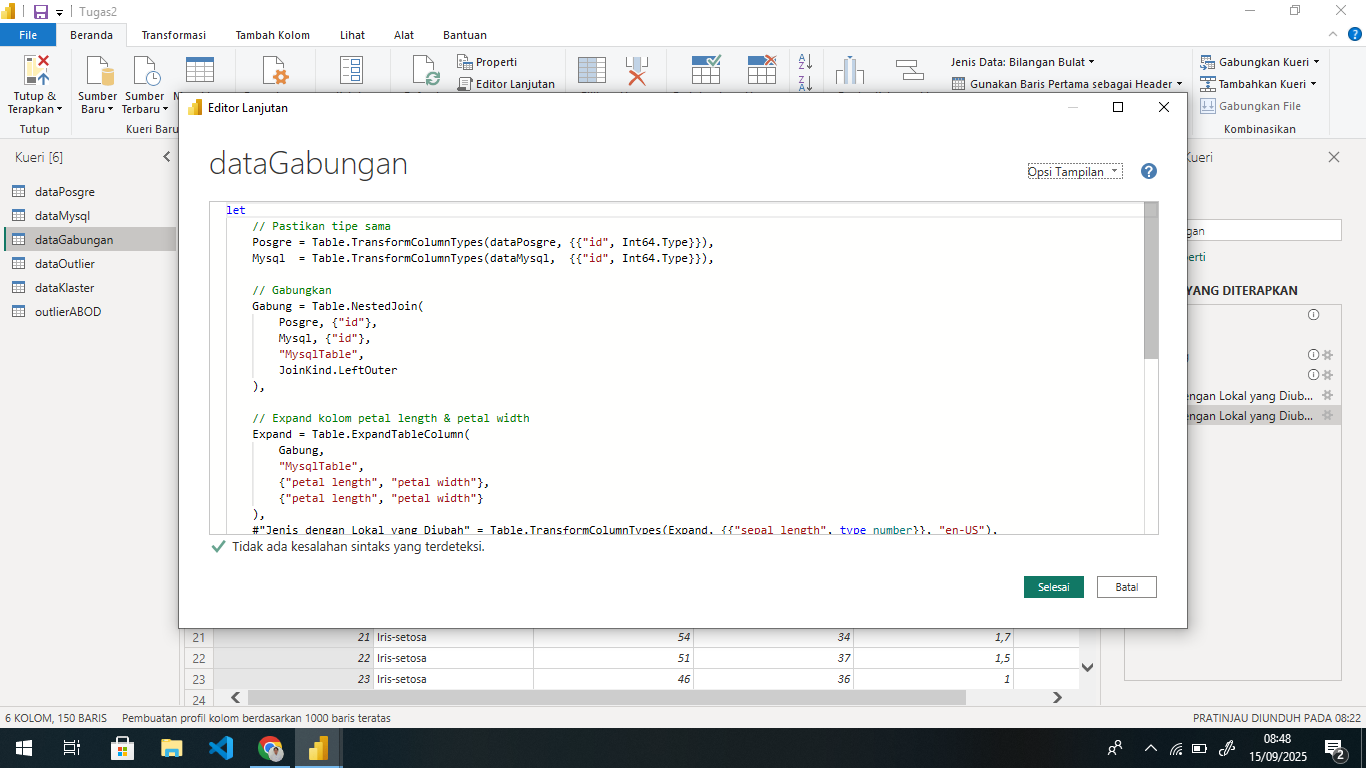

In [ ]:
let
    // Pastikan tipe sama
    Posgre = Table.TransformColumnTypes(dataPosgre, {{"id", Int64.Type}}),
    Mysql  = Table.TransformColumnTypes(dataMysql,  {{"id", Int64.Type}}),

    // Gabungkan
    Gabung = Table.NestedJoin(
        Posgre, {"id"},
        Mysql, {"id"},
        "MysqlTable",
        JoinKind.LeftOuter
    ),

    // Expand kolom petal length & petal width
    Expand = Table.ExpandTableColumn(
        Gabung,
        "MysqlTable",
        {"petal length", "petal width"},
        {"petal length", "petal width"}
    ),

    // Ubah tipe kolom numerik
    #"Jenis dengan Lokal yang Diubah"  = Table.TransformColumnTypes(Expand, {{"sepal length", type number}}, "en-US"),
    #"Jenis dengan Lokal yang Diubah1" = Table.TransformColumnTypes(#"Jenis dengan Lokal yang Diubah", {{"sepal width", type number}}, "en-US"),

    // Python script ABOD + Outlier 2%
    PyCaretOutlier = Python.Execute("
import pandas as pd
from pycaret.anomaly import setup, create_model, assign_model

dataset = dataset

# setup
s = setup(
    data=dataset,
    session_id=123,
    numeric_features=['sepal length', 'sepal width', 'petal length', 'petal width']
)

# model ABOD
model = create_model('abod')
outliers = assign_model(model)

# urutkan berdasarkan Anomaly_Score (descending)
outliers_sorted = outliers.sort_values(by='Anomaly_Score', ascending=False).reset_index(drop=True)

# hitung 2% data teratas
top_n = max(1, int(len(outliers_sorted) * 0.02))

# tambahkan kolom label
outliers_sorted['OutlierLabel'] = ['Yes' if i < top_n else 'No' for i in range(len(outliers_sorted))]

outliers_sorted
", [dataset=#"Jenis dengan Lokal yang Diubah1"]),

    Result = PyCaretOutlier{[Name="outliers_sorted"]}[Value]
in
    Result

5. Filter data yang mengandung outlier dengan value yes pada outlierlabel di tabel power BI

![image.png](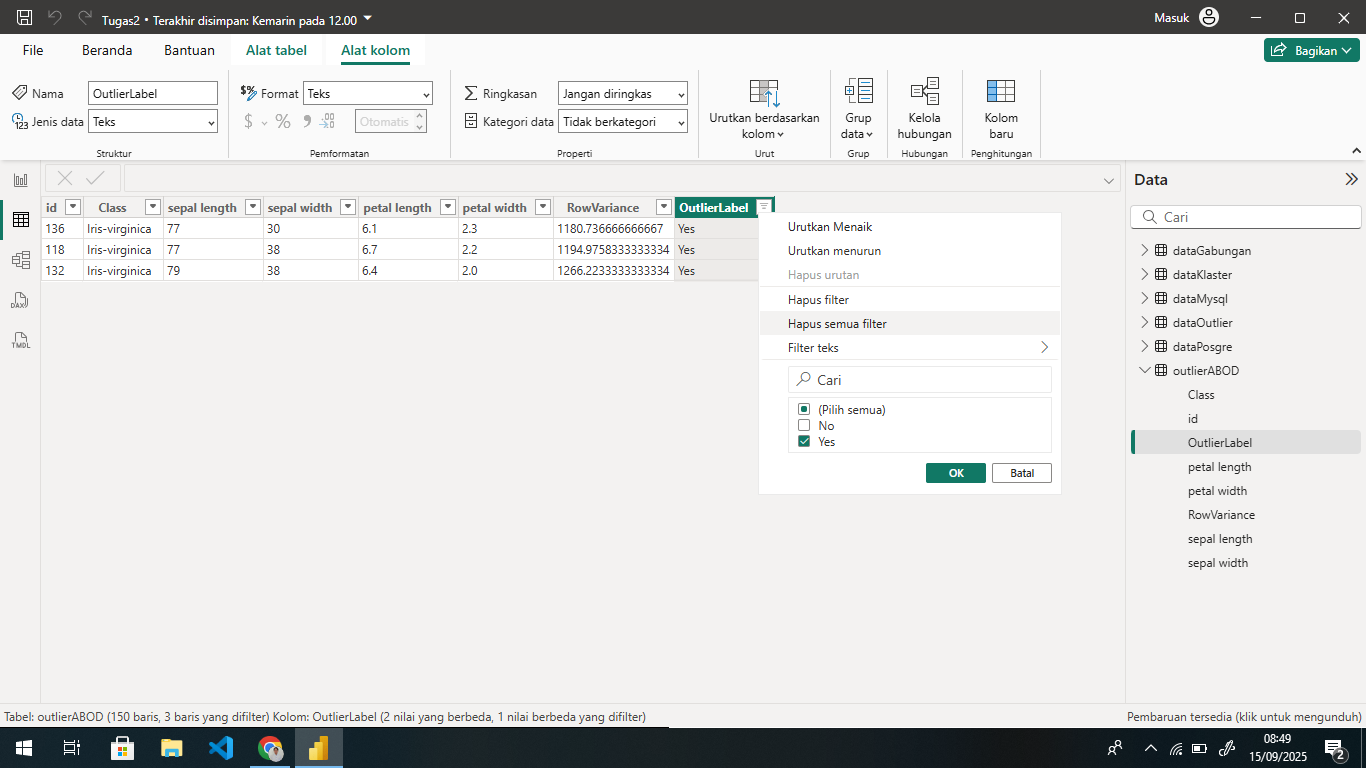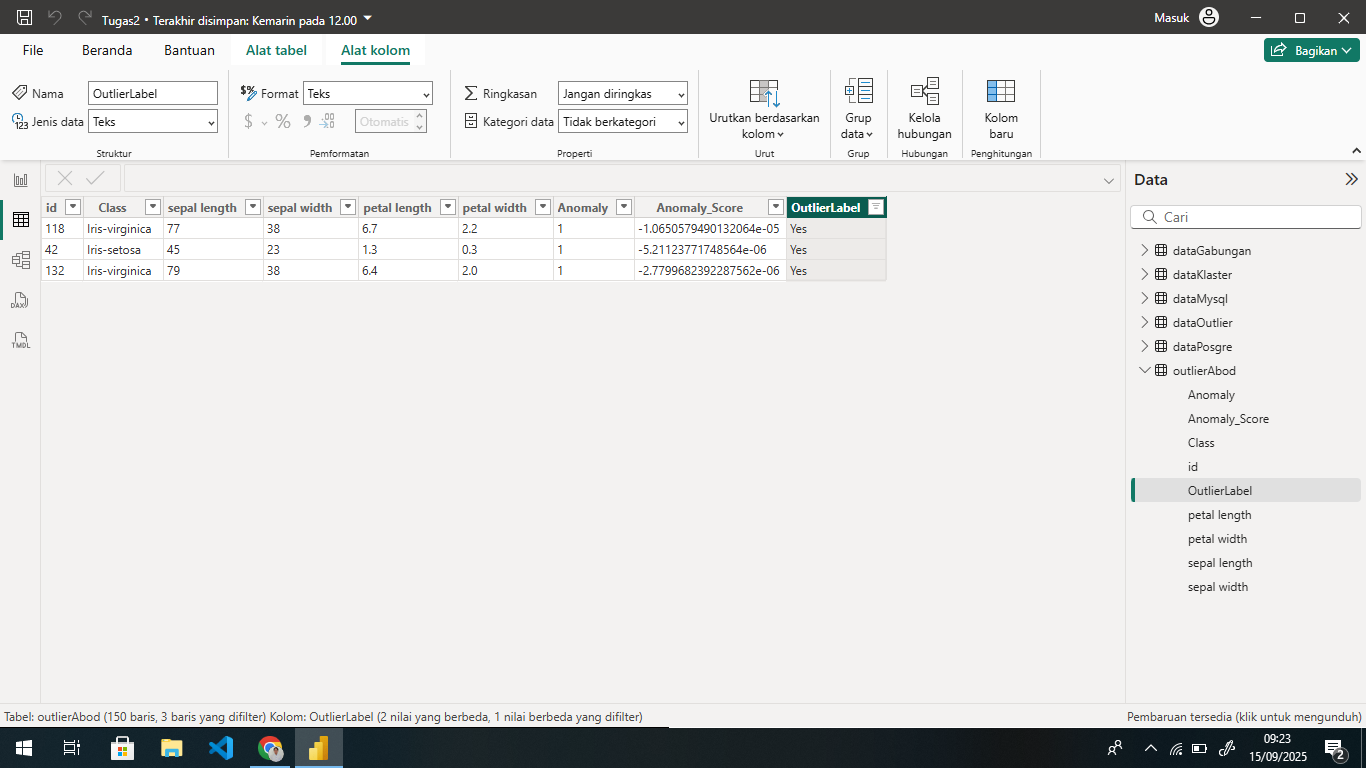)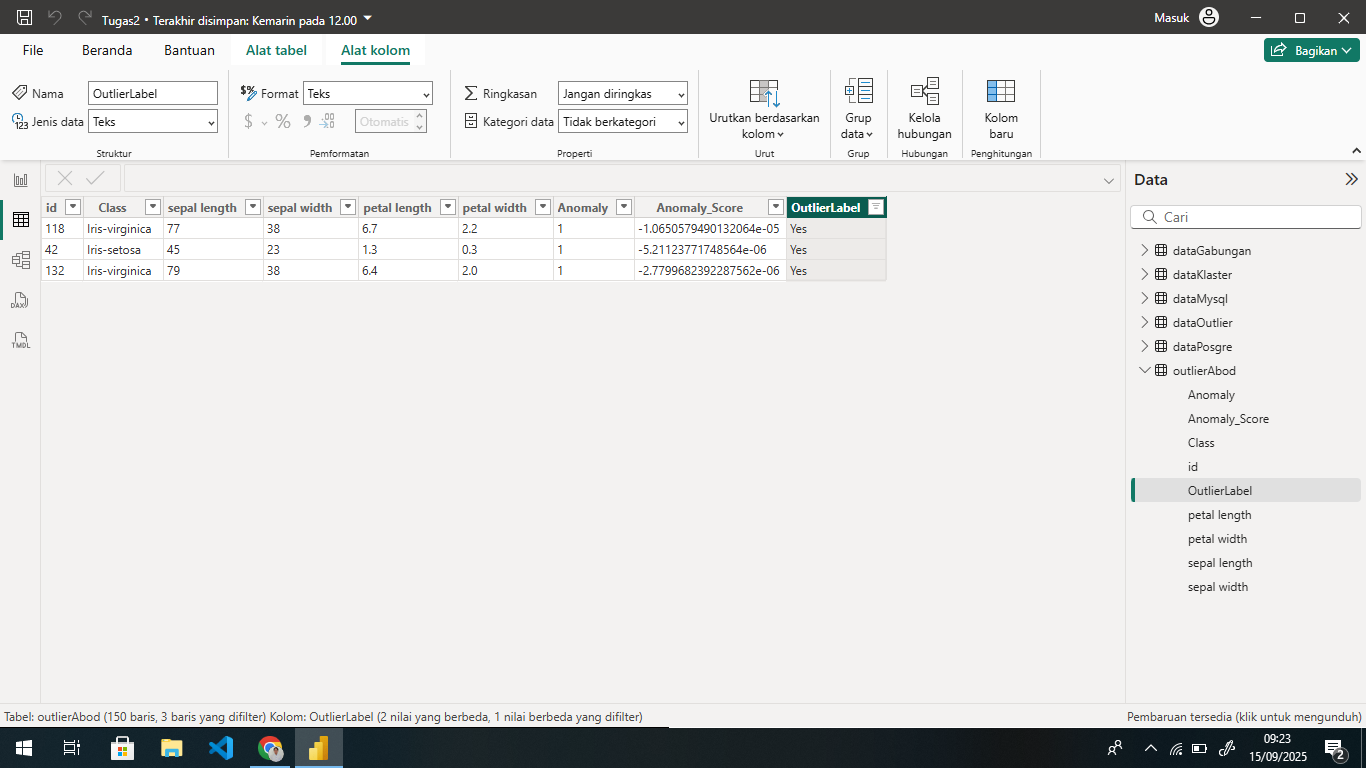

6. Pada menu ubah data klik hapus baris dengan outlier label yes


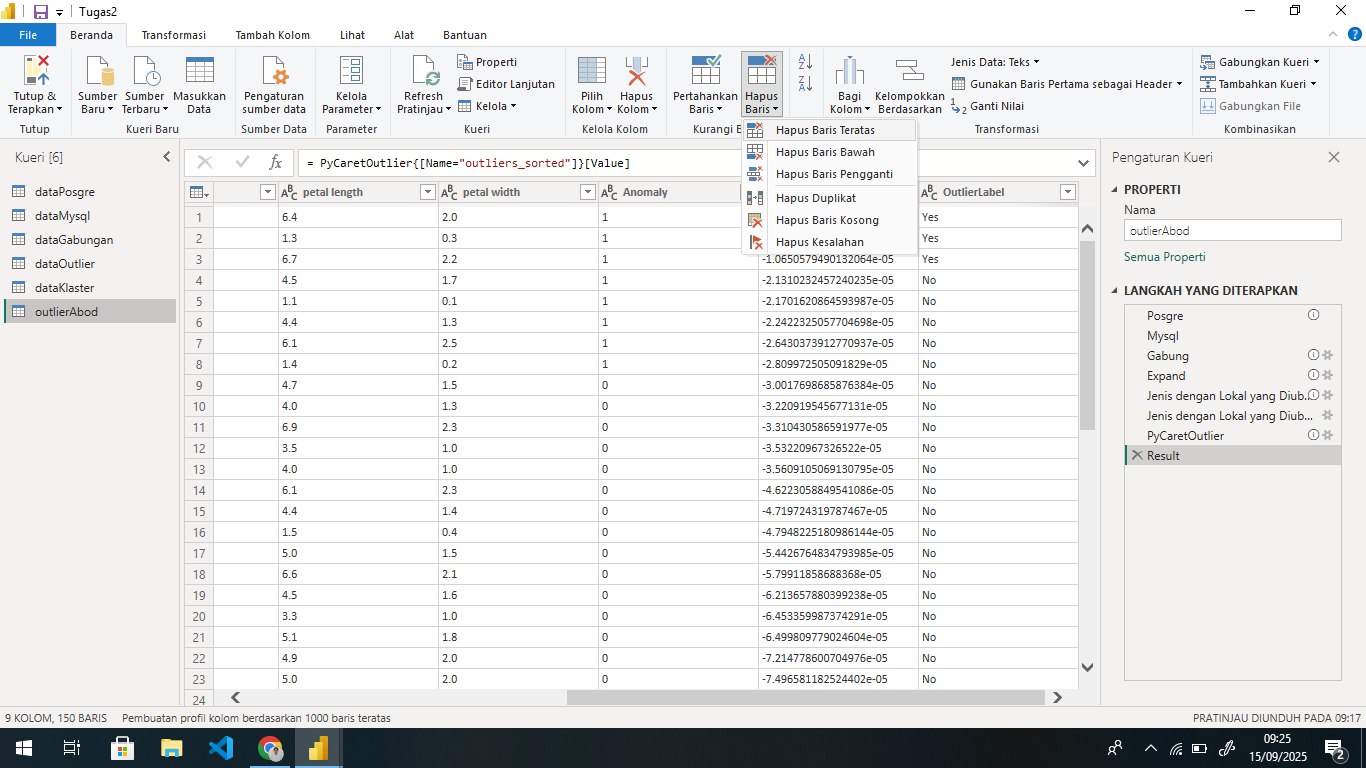

7. karena oulier merupakan value yes pada kolom outlier label berada pada 3 teratas maka hapus baris 3 teratas kemudian oke maka data akan bersih dari outlier

8. Data sudah bersih dari 2% outlier

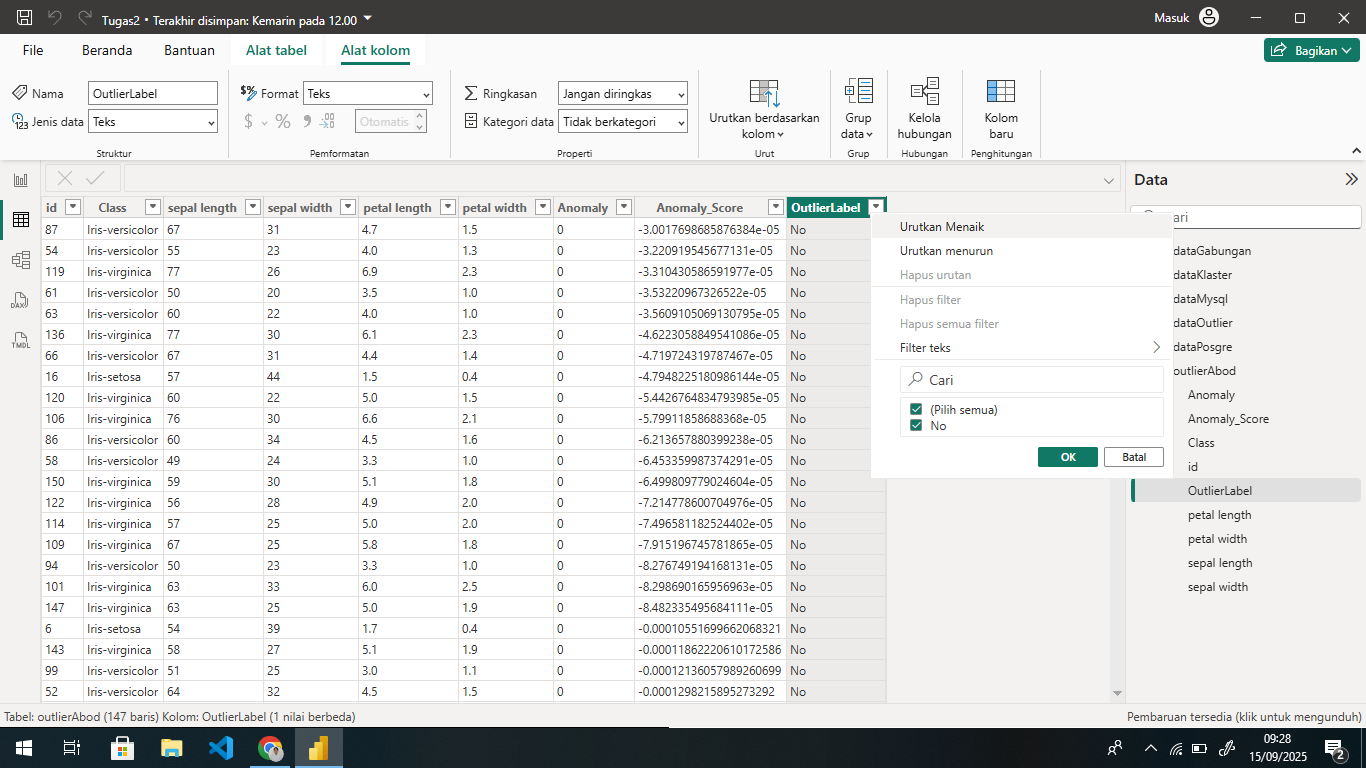

### Klastering menggunakan K-Means

K-Means adalah Teknik pengelompokan (clustering) berbasis partisi membagi data menjadi K kelompok berdasarkan jarak setiap kelompok direpresentasikan oleh centroid(rata-rata jarak dari titik dalam kluster) atau biasa disebut titik pusat suatu klaster.

Data yang sering kali tidak memiliki label-->Unsupervised learning clustering membantu mengelompokkan data berdasarkan kesamaan karakteristik

#### tujuan dan fungsi klustering

#### Tujuan dan Fungsi Klaster (Clustering)

**Clustering** adalah salah satu teknik utama dalam **unsupervised learning** yang bertujuan untuk mengelompokkan data berdasarkan kemiripan atau kedekatan karakteristik tanpa menggunakan label atau target output. Klastering sering digunakan dalam data mining, analisis data eksploratif, segmentasi pasar, dan banyak bidang lain.

---

##### 🎯 **Tujuan Klastering**

1. **Mengelompokkan Data Serupa**
   Tujuan utama klastering adalah mengelompokkan data ke dalam beberapa **kelompok (klaster)** sedemikian rupa sehingga:

   * Data dalam satu klaster **mirip** satu sama lain (intra-cluster similarity tinggi).
   * Data antar klaster **berbeda jauh** (inter-cluster dissimilarity tinggi).

2. **Reduksi Kompleksitas Data**
   Dengan membagi data ke dalam klaster, kita bisa menyederhanakan analisis data, terutama saat bekerja dengan data besar dan kompleks.

3. **Mengidentifikasi Pola atau Struktur Tersembunyi**
   Klastering dapat membantu mengungkap pola tersembunyi dalam data yang mungkin tidak tampak secara langsung.

4. **Segmentasi**
   Dalam dunia bisnis dan pemasaran, klastering digunakan untuk membagi pelanggan ke dalam segmen berdasarkan perilaku atau atribut tertentu (misalnya: segmentasi pelanggan, segmentasi wilayah, dll).

---

#### 🛠️ **Fungsi Klastering dalam Analisis Data**

| Fungsi                           | Penjelasan                                                                                          |
| -------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Eksplorasi Data**              | Klaster membantu memahami struktur data, mendeteksi outlier, dan mengidentifikasi grup penting.     |
| **Pra-pemrosesan**               | Dapat digunakan sebelum algoritma supervised learning untuk menyaring atau mengelompokkan data.     |
| **Rekomendasi Sistem**           | Sistem rekomendasi sering menggunakan klastering untuk menemukan grup pengguna dengan minat serupa. |
| **Pengelompokan Dokumen / Teks** | Untuk mengelompokkan artikel, berita, atau dokumen berdasarkan topik utama.                         |
| **Deteksi Anomali**              | Data yang tidak masuk ke klaster manapun bisa dianggap sebagai anomali atau outlier.                |
| **Biologi / Genetika**           | Untuk mengelompokkan gen, ekspresi gen, atau jenis sel berdasarkan karakteristik biologis.          |


### Langkah Langkah Algoritma K-Means

1. Tentukan jumlah cluster
Disini saya akan mencoba dengan data yang ditampilkan membaginya dengan 2,3,4 klaster
2. Pilih K centroid awal secara acak setiap klaster memiliki 1 centroid
3. Hitung jarak setiap data ke tiap centroid
gunakan rumus Encludian Distance
$$
d(\mathbf{x}, \mathbf{c}) = \sqrt{ \sum_{i=1}^{n} (x_i - c_i)^2 }
$$


#### Penjelasan:

* $\mathbf{x} = (x_1, x_2, \ldots, x_n)$: vektor data.
* $\mathbf{c} = (c_1, c_2, \ldots, c_n)$: vektor centroid.
* $n$: jumlah dimensi atau fitur.
* $d(\mathbf{x}, \mathbf{c})$: jarak Euclidean antara data dan centroid.

4. Kelompokan data dengan centroid terdekat
5. Hitung ulang centroid dari rata rata anggota kluster
$$
\mu_k = \frac{1}{N_k} \sum_{x_i \in C_k} x_i
$$
#### ✅ Penjelasan:

* **\$\mu\_k\$**
  Menyatakan **centroid (titik pusat)** dari klaster ke-**\$k\$**.

* **\$N\_k\$**
  Jumlah **data (anggota)** yang terdapat dalam klaster ke-**\$k\$**.

* **\$x\_i \in C\_k\$**
  Menyatakan bahwa **\$x\_i\$** adalah titik data yang termasuk ke dalam klaster **\$C\_k\$**.

* **\$\sum\_{x\_i \in C\_k} x\_i\$**
  Menyatakan jumlah (penjumlahan vektor) dari seluruh titik data yang berada di dalam klaster **\$C\_k\$**.

* **\$\frac{1}{N\_k}\$**
  Digunakan untuk menghitung rata-rata dari semua anggota dalam klaster tersebut.

6. Ulangi langkah 3-5 hingga konvergen(tidak ada perubahan signifikan)



Pada Kolom sepal Length ini dibagi kedalam 4 klaster yaitu A,B,C,D

1. Duplikad data gabungan beri nama data klaster

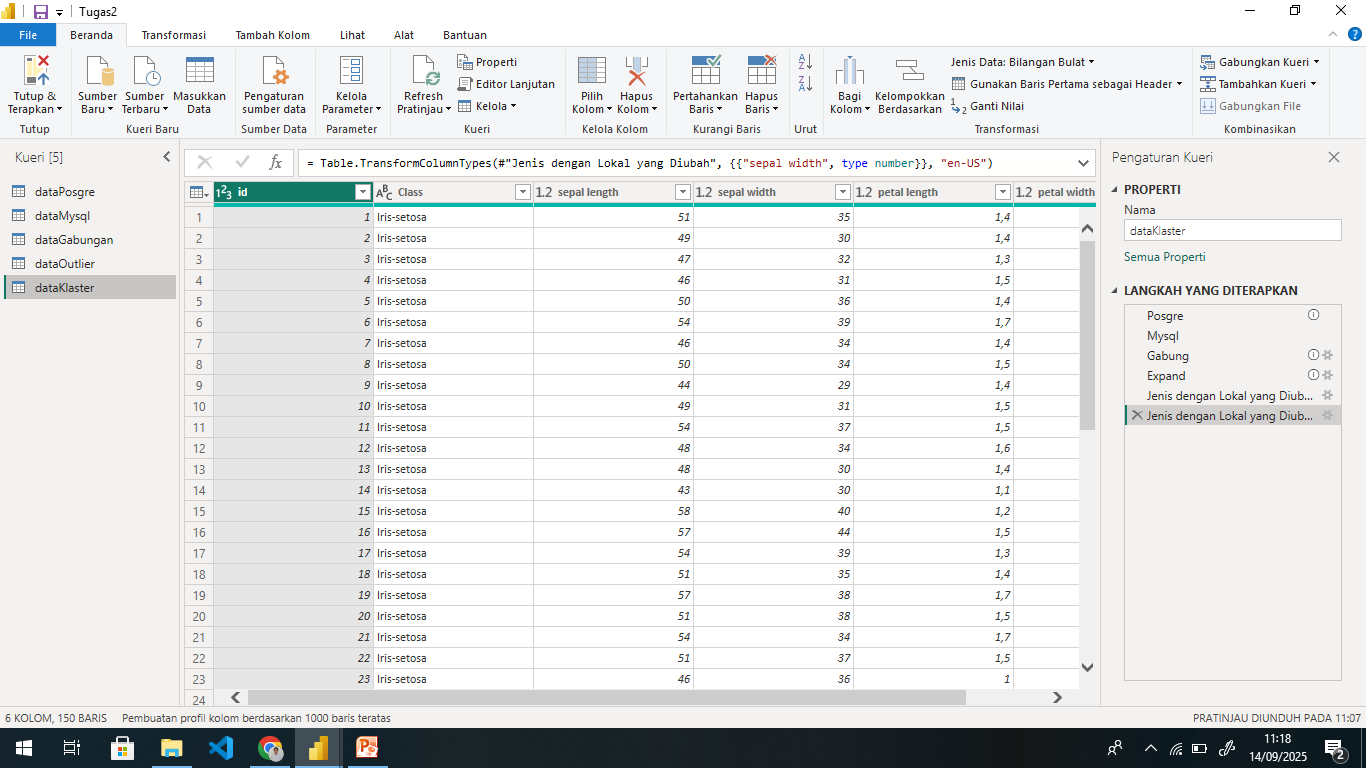

2. Lakukan hal yang sama dengan deteksi oulier menggunakan KNN

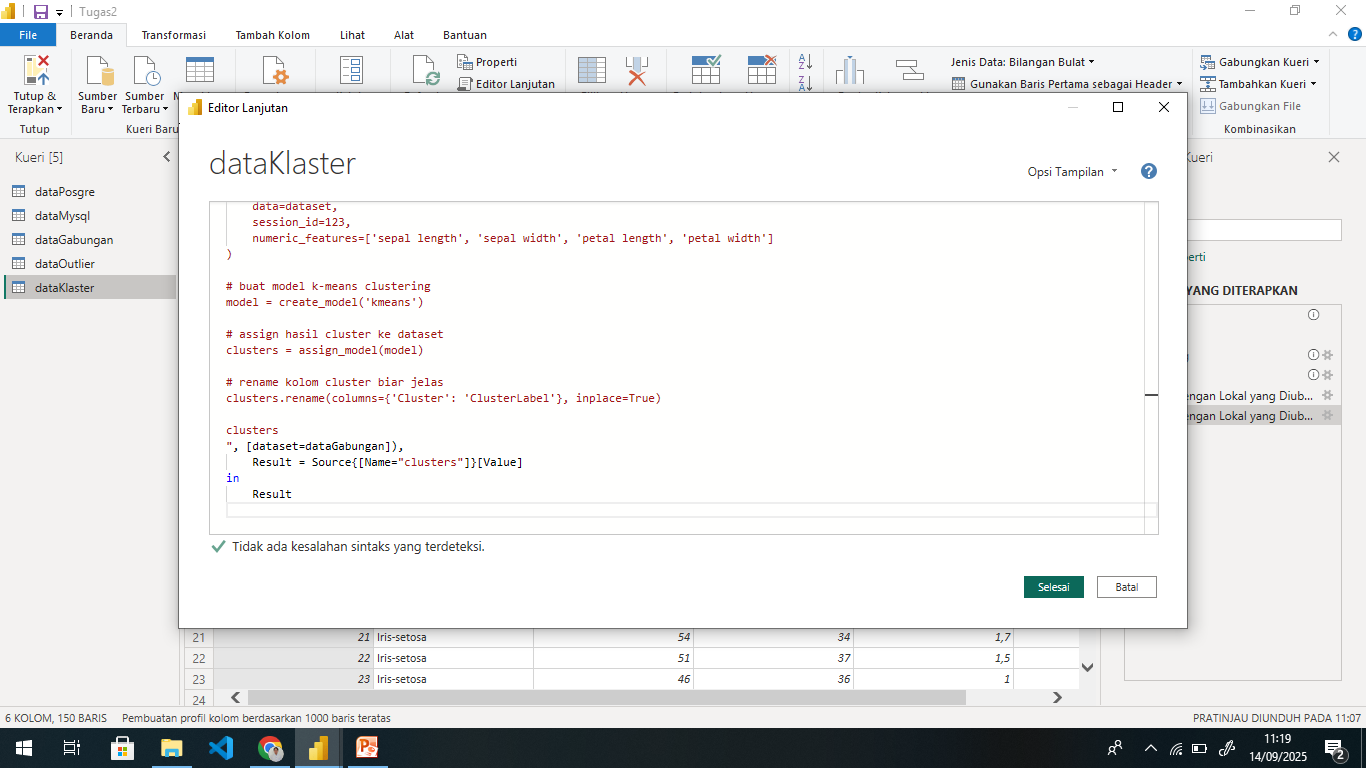

In [ ]:
let
    Source = Python.Execute("
import pandas as pd
from pycaret.clustering import setup, create_model, assign_model

# ambil dataset dari Power BI
dataset = dataset

# inisialisasi pycaret clustering
s = setup(
    data=dataset,
    session_id=123,
    numeric_features=['sepal length', 'sepal width', 'petal length', 'petal width']
)

# buat model k-means clustering
model = create_model('kmeans')

# assign hasil cluster ke dataset
clusters = assign_model(model)

# rename kolom cluster biar jelas
clusters.rename(columns={'Cluster': 'ClusterLabel'}, inplace=True)

clusters
", [dataset=dataGabungan]),
    Result = Source{[Name="clusters"]}[Value]
in
    Result


3. setelah klik selesai edit izin beri izin

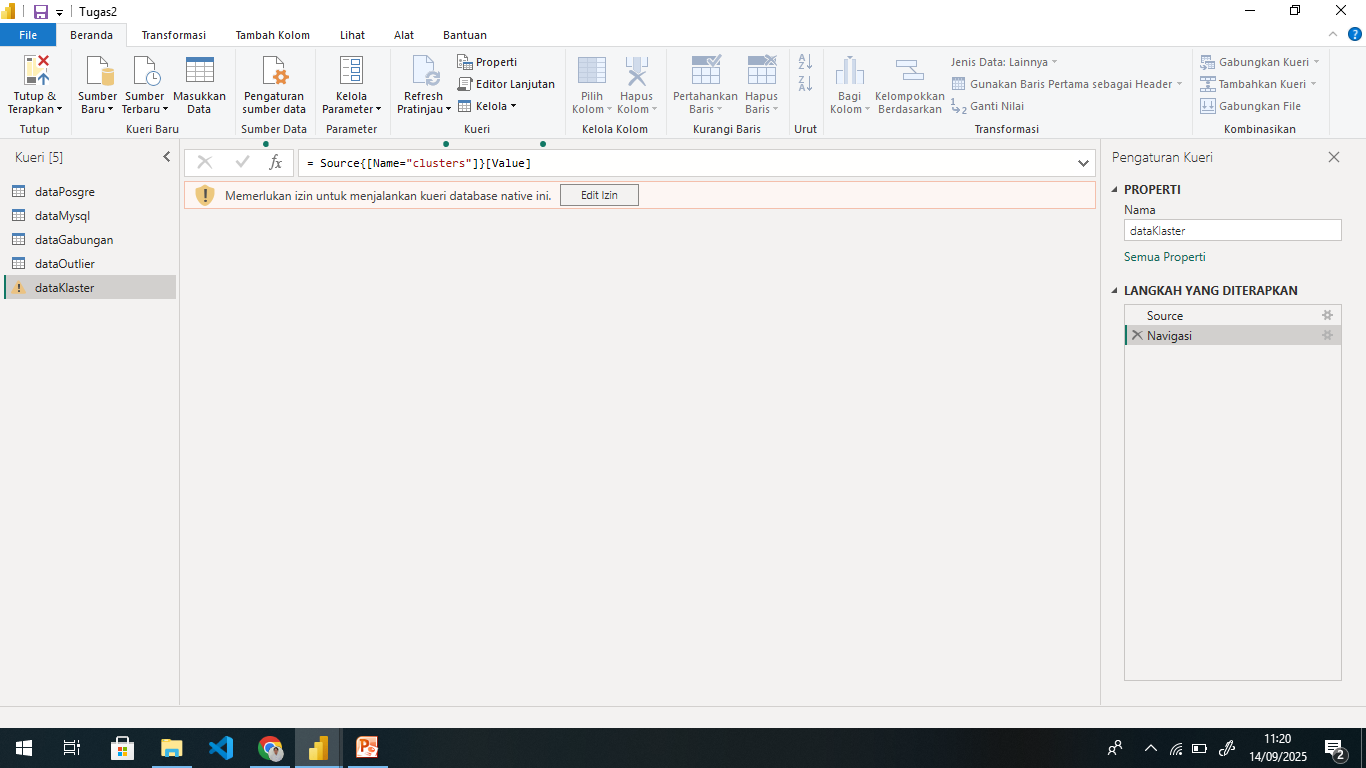

4. Setelah itu maka akan muncul tabel baru

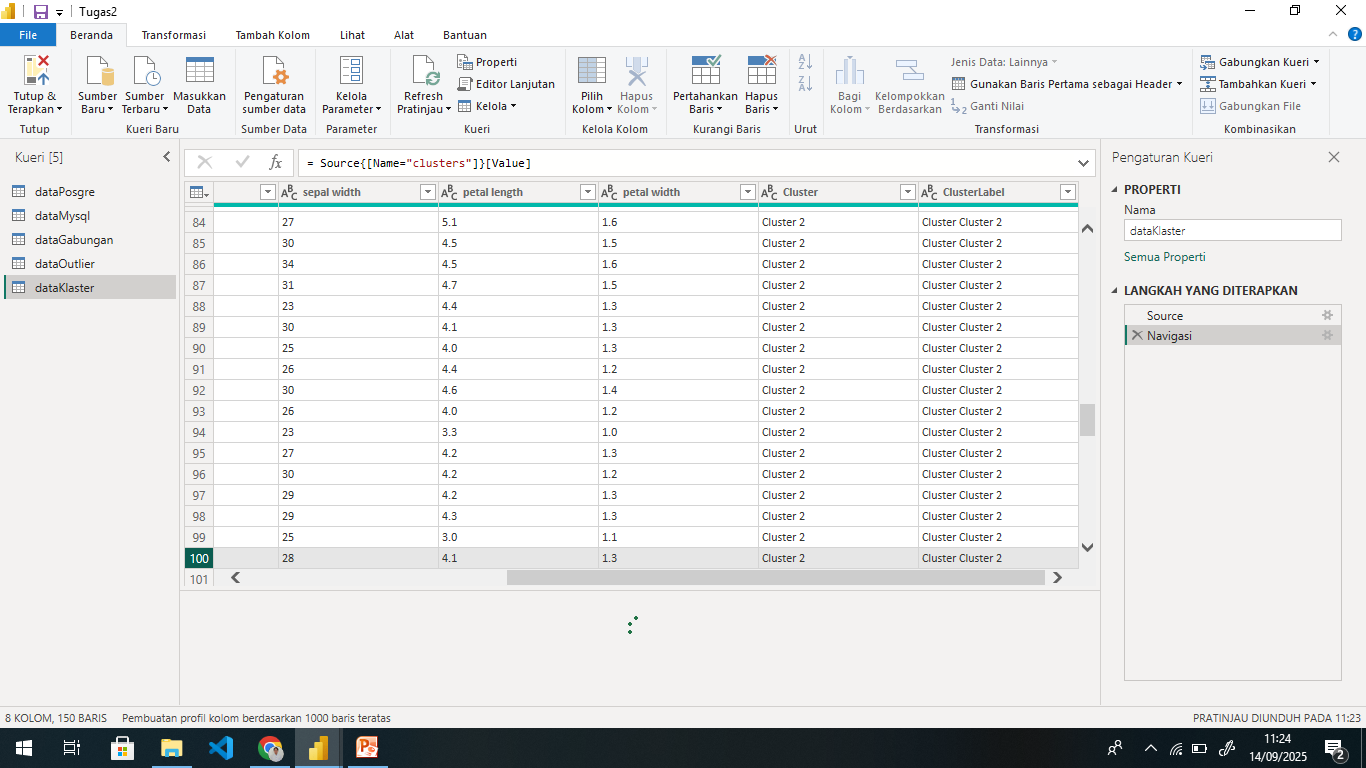